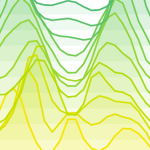

# Topological phase data and analysis

This Jupyter notebook performs all the analysis and generates the plots that appear in the paper _"InAs-Al Hybrid Devices Passing the Topological Gap Protocol"_ by Microsoft Quantum, available as a pre-print on [arXiv:2207.02472](https://arxiv.org/abs/2207.02472).
See that paper for complete explanations and in-depth descriptions.

The analysis here relies on the topological gap protocol as described in [arXiv:2103.12217](https://arxiv.org/abs/2103.12217).
The protocol itself is a method to analyze a set of device conductance data and automatically determine whether a topological phase is present.
It does this by testing for the presence of conductance peaks at zero applied voltage at both ends of the device and simultaneously testing for a gap closing and reopening in the bulk of the device.
The topological phase is present when both these conditions are met, and the topological gap is the size of the gap opening in the bulk of the device.
For further information on the structure of the devices themselves please refer to [the pre-print](https://arxiv.org/abs/2207.02472).

The topological protocol is split in two stages.
Stage 1 analyzes a broad set of _local_ conductance data to find zero bias peaks (ZBPs) and then identify regions of interest in the data containing zero bias peaks at each end of the device.
These regions are then further analyzed in stage 2 by examining the _non-local_ conductance (current response at one end of the device to a voltage applied at the other end).
When the non-local conductance shows a gap closing and re-opening (i.e., the peak in conductance vs.
voltage bias applied converges at zero-bias and then moves away from zero bias), this is an indication that the device is in the topological phase.
An annotated guide to stage 1 and stage 2 can be found in the notebooks "stage-one-analysis" and "stage-two-analysis".
The exact same procedure is applied in this notebook.

### Notes about input parameters

This notebook contains a few one-off plots and two analysis/plot types that occur multiple times: stage 1 clusters and stage 2 phase diagrams.
The analysis/plot parameters can be modified; main parameters are summarized in the following table.

| Parameter name | Description | Example value |
| --- | --- | --- |
| `name` | Name of the device and stage, the saved plot's filename is based on this. | `"deviceA_stage1"` |
| `selected_cutter` | The paired cutter gate index of which the gap value is used. | `0` |
| `selected_field` | Magnetic field value at which a cut of the data is plotted. | `1.82` |
| `selected_plunger` | Plunger gate value at which a cut of the data is plotted. | `-2.721` or `[-1.36575, -1.37275]` |
| `T_mK` | Temperature in milli-Kelvin with which the simulation data is broadened. | `30.0` |
| `thresholds` | Dictionary of stage 1 input parameters, see the `stage-one-analysis.ipynb` notebook for more details. | `{"th_2w_p": 0.5, "th_3w": 1e3, "th_3w_tat": 0.7}` |
| `zbp_cluster_numbers` | The selected gapped ZBP cluster(s) that is (are) plotted. The clusters are sorted on size, where the biggest cluster is `1`.  | `[1]` |

For the first step we load the analysis functions from [the installable Python package `tgp` available on PyPI and GitHub](https://github.com/microsoft/azure-quantum-tgp).


In [ ]:
import shutil
from pathlib import Path

folder = Path("../data/")
# We move the `paper_figures.py` module to the right place
if not folder.exists():
    folder = Path("/usr/tgp/data")
    shutil.copy(folder / "paper_figures.py", ".")

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import paper_figures
import xarray as xr
from matplotlib.patches import Rectangle
from paper_figures import (
    analyze_two,
    correct_two,
    load,
    load_cached_broadened,
    maybe_save_fig,
    plot_1d_phase_diagram,
    plot_clean_gap,
    plot_conductance_cuts,
    plot_conductance_traces,
    plot_disorder_strength_vs_n2D,
    plot_Hall_bar,
    plot_local_and_non_local_conductance,
    plot_pf,
    plot_xi,
    set_saving_figures,
)
from scipy.ndimage import gaussian_filter

import tgp
import tgp.plot.paper

# Change this flag to False to not save the figures to pdf
# and set a folder where to save the figures
set_saving_figures(True, folder="figures")

tgp.plot.set_mpl_rc()


def text_kwargs(axs):
    return dict(
        c="k",
        ha="left",
        va="bottom",
        size=16,
        transform=axs[0].transAxes,
        zorder=2000,
    )

## Additional information about experimental devices
The extraction of the effective parameters below are decribed in the main text.
* `lever_arm`: see Sec. "Electrostatic calibration from Hall bars"
* `g_factor` is defined as $|g_\mathrm{eff}| \equiv 2\Delta_\mathrm{ind} / \mu_\mathrm{B} B_\mathrm{min}$, where $B_\mathrm{min}$ is the lowest field at which the gap closes; see also Sec. "TGP Stage 2: Measurement A1"

In [ ]:
device_info = dict(
    deviceA1=dict(lever_arm=85, g_factor=5.6),
    deviceA2=dict(lever_arm=85, g_factor=6.4),
    deviceA3=dict(lever_arm=85, g_factor=6.4),
    deviceB=dict(lever_arm=78, g_factor=3.7),
    deviceC=dict(lever_arm=79, g_factor=4.4),
    deviceD=dict(lever_arm=79, g_factor=4.5),
)

# Fig. 1: Energy spectrum & topological phase diagram

The simplest, idealized model of Microsoft Quantum topological devices consists of a semiconductor nanowire coupled to a conventional superconductor, where the semiconductor nanowire has Rashba spin-orbit interaction.
The effective model for this is shown in equation (1) of [the paper](https://arxiv.org/abs/2207.02472) and results in an energy spectrum (a) and topological phase diagram (b) as in figure 1 from the paper.
The topological phase (in red) arises as Zeeman energy (from a magnetic field in-line with the nanowire) increases and creates a gap in the energy spectrum.
The trivial superconducting phase is in blue.

In [ ]:
plot_1d_phase_diagram("energy_spectrum_topophase.pdf")

# Fig. 4: Phase diagram simulation of SLG-$\beta$ and DLG-$\varepsilon$ infinite clean device

A realistic device is much more complicated than the above idealized device.
Microsoft Quantum has modeled realistic device geometries including the actual semiconductor and superconductor materials as well as the 3-dimensional gate and junction shapes.
The model here uses the single-layer junction device design on the $\beta$ stack, but ignores any disorder or defects, and uses an infinite wire length.
The simulation identifies multiple topological phases (as shown in red) at different "plunger" gate voltages (vertical axis) and magnetic fields (horizontal axis).
As before, blue reflects the trivial superconducting phase.
In real devices, the non-zero disorder and finite wire length will decrease the size of the topological phases.

*(May take around 45 seconds to complete.)*

In [ ]:
ds = xr.load_dataset(folder / "simulated" / "infinite_clean_gap_SLG.nc", engine="h5netcdf")
plot_clean_gap(ds, plunger_min=-1.4, label="a", fname="simulated_SLG_beta_infinite_clean_gap.pdf")

Like the previous figure, the following figure is a model of a realistic device, this time with a dual-layer junction device design on the $\epsilon$ stack.
Disorder and defects are again set to zero, and the wire is modeled with an infinite length.

*(May take around 45 seconds to complete.)*

In [ ]:
ds = xr.load_dataset(folder / "simulated" / "infinite_clean_gap_DLG.nc")
plot_clean_gap(ds, plunger_min=-1.2, label="b", fname="simulated_DLG_beta_infinite_clean_gap.pdf")

# Fig. 6: Phase diagram simulation of single-band disordered device

The simulations now add a further degree of realism, including both an expected level of disorder as well as finite device length.
The disorder is modeled as local variations in potential and is randomized to create different disorder realizations.
The figures below are for simulations of two different disorder realizations corresponding to different disorder strengths.
Here, red indicates points in the topological phase, and black indicates points in the topological case that additionally have a gap in excess of 10 µeV.

In [ ]:
ds_pf = xr.load_dataset(folder / "simulated" / "DLG_epsilon_stack_pfaffian.nc")

plot_pf(
    ds_pf.isel(rms=0, seed=0),
    ds_pf.isel(rms=1, seed=2),
    ylim=(-1, 2),
    fname="pd_pfaffian.pdf",
)

# Fig. 8: Device A, measurement A1 (stage 1)

The protocol has also been applied to experimental measurements of real devices.
Device A is analyzed for stage 1 in the same way as the simulated data.
The regions in the magnetic field and plunger gate voltage space with zero bias peaks on the left (a), and right of the device (b), followed by the joint fraction — having a simultaneous zero bias peak on both sides — in (c).

We use a manually set threshold `th_3w = 0.3e7` to filter out noise in $3\omega$ signal. 
Note that the positions and sizes of the regions with zero bias peaks are insensitive to the choice of `th_3w` threshold within an order of magnitude.

In [ ]:
name = "deviceA_stage1"
thresholds = dict(
    set_gapped={"th_2w_p": 0.7},
    set_3w_th={"th_3w": 0.3e7},
    set_3w_tat={"th_3w_tat": 0.7},
)

In [ ]:
ds = load(folder / "experimental" / f"{name}.nc")
tgp.one.analyze(ds, thresholds=thresholds)

tgp.plot.paper.plot_stage1_clusters(
    ds.L_3w_ta,
    ds.R_3w_ta,
    ds.L_3w_tat,
    ds.R_3w_tat,
    thp=ds.attrs["set_3w_tat.th_3w_tat"],
    xy_text=(0.04, 0.70),
    text="Device A",
    ylim=(-1.18, -1.15),
)
maybe_save_fig(f"{name}.pdf")

# Fig. 9: Device A, measurement A1 (stage 2)

Device A is then analyzed in the region of interest using non-local conductance for stage 2.
As in figure 13, a region of magnetic field and plunger voltage is identified that has a gapless boundary, a gap in the interior, and zero bias peaks (a), and therefore constitutes an SOI$_2$.
The size of the gap is shown by the red scale in (b), with blue being the gap size in the trivial superconducting regime.
Selected cuts of the conductance through the identified topological region are shown for local conductance (c, d) as well as non-local (e, f).
As with the simulated data, the real device data here shows zero bias peaks in the local conductance and a closing and re-opening of a gap in the non-local conductance as magnetic field is increased.
(g, h, i, and j) show a waterfall view of the conductance data with bias now on the x-axis and magnetic field on the y-axis.
The presence of zero bias peaks are now visible as a peak replicated vertically (g, h) and finite conductance values converging and then re-opening (i, j).
The dots in (i, j) show extracted gap values.

In [ ]:
name = "deviceA1_stage2"
zbp_cluster_numbers = [1]
selected_cutter = 0
selected_plunger = -1.17175
selected_field = 1.66

In [ ]:
fnames = (
    folder / "experimental" / f"{name}_left.nc",
    folder / "experimental" / f"{name}_right.nc",
)
ds_left, ds_right = (load(fn) for fn in fnames)

(ds_left, ds_right), (ds_c_left, ds_c_right) = correct_two(
    ds_left,
    ds_right,
    lockin_left="lockin_1",
    lockin_right="lockin_2",
    fridge_parameters=folder / "fridge" / "deviceA1.yaml",
    drop_indices=[0, 1, 2],
    max_bias_index=-2,
    norm=1e3,
    phase_shift_left=-3.3,
    phase_shift_right=-5.57,
)

result = analyze_two(ds_c_left, ds_c_right)

In [ ]:
fig, axs = tgp.plot.paper.plot_stage2_diagram(
    result.zbp_ds,
    cutter_value=selected_cutter,
    zbp_cluster_numbers=zbp_cluster_numbers,
    plunger_cut=selected_plunger,
    field_cut=selected_field,
    device_info=device_info[name.split("_")[0]],
    pct_boundary_shifts={1: [0.28, -0.001]},
)
plt.text(-0.476, 1 - 0.07, "Device A,", **text_kwargs(axs))
plt.text(-0.476, 1 - 0.13, "measurement A1", **text_kwargs(axs))
maybe_save_fig(f"{name}_diagram.pdf")
plt.show()

In [ ]:
fig, (ax1, ax2, ax3, ax4) = tgp.plot.paper.plot_conductance(
    result.zbp_ds,
    result.ds_left,
    result.ds_right,
    selected_cutter=selected_cutter,
    selected_plunger=selected_plunger,
    zbp_cluster_numbers=zbp_cluster_numbers,
    field_ticks=[0.5, 1, 1.5, 2.0, 2.5],
    g_local_max=0.8,
    g_nonlocal_max=0.08,
)
maybe_save_fig(f"{name}_conductance.pdf")
plt.show()

In [ ]:
fig, (ax1, ax2, ax3, ax4) = tgp.plot.paper.plot_conductance_waterfall(
    result.zbp_ds,
    result.ds_left,
    result.ds_right,
    selected_cutter=selected_cutter,
    selected_plunger=selected_plunger,
    zbp_cluster_numbers=zbp_cluster_numbers,
    field_lim=[0.72, 2.73],
    bias_max=0.06,
    scale_g_local=0.15,
    gbar_local=0.5,
    scale_g_nonlocal=0.6,
    gbar_nonlocal=0.1,
)
maybe_save_fig(f"{name}_conductance_waterfall.pdf")
plt.show()

# Fig. 10: Device A, measurement A1 (stage 2), plunger waterfall plot

The zero-bias peaks in local conductance (a,b) and gap closing and re-opening in non-local conductance (c, d) are also visible over a range of plunger voltage values (with magnetic field held constant), demonstrating that the identified topological phase is robust over both magnetic field and plunger voltage.

In [ ]:
fig, axs = tgp.plot.paper.plot_conductance_waterfall_plunger(
    result.zbp_ds,
    result.ds_left,
    result.ds_right,
    selected_cutter,
    selected_field,
    zbp_cluster_numbers,
    plunger_lim=(-1.1753, -1.1663),
    bias_max=0.06,
    bias_ticks=np.arange(-50, 51, 25),
    scale_g_local=0.0007,
    gbar_local=0.5,
    scale_g_nonlocal=(0.006, 0.0015),
    gbar_nonlocal=(0.05, 0.25),
    g_bar_pos=-0.0003,
    text="Device A, measurement A1",
)
maybe_save_fig(f"{name}_conductance_waterfall_plunger.pdf")
plt.show()

# Fig. 11: Device A, measurement A2 (stage 2)

The following generates the same plots as for figures 13 and 15, but now for a different measurement of device A after the device had been warmed up and re-measured in a different experimental setup.

In [ ]:
name = "deviceA2_stage2"
zbp_cluster_numbers = [1]
selected_cutter = 1
selected_plunger = -1.4045
selected_field = 1.14666667

In [ ]:
fnames = (
    folder / "experimental" / f"{name}_left.nc",
    folder / "experimental" / f"{name}_right.nc",
)
ds_left, ds_right = (load(fn) for fn in fnames)

(ds_left, ds_right), (ds_c_left, ds_c_right) = correct_two(
    ds_left,
    ds_right,
    lockin_left="mfli_5510",
    lockin_right="mfli_5602",
    fridge_parameters=folder / "fridge" / "deviceA2.yaml",
    drop_indices=[0, 1, 2],
    max_bias_index=-2,
    norm=1e3,
)

result = analyze_two(ds_c_left, ds_c_right)

In [ ]:
fig, axs = tgp.plot.paper.plot_stage2_diagram(
    result.zbp_ds,
    cutter_value=selected_cutter,
    zbp_cluster_numbers=zbp_cluster_numbers,
    plunger_cut=selected_plunger,
    device_info=device_info[name.split("_")[0]],
    pct_boundary_shifts={1: [0.24, -0.0016]},
)
plt.text(-0.467, 1 - 0.07, "Device A,", **text_kwargs(axs))
plt.text(-0.467, 1 - 0.13, "measurement A2", **text_kwargs(axs))
maybe_save_fig(f"{name}_diagram.pdf")
plt.show()

In [ ]:
fig, (ax1, ax2, ax3, ax4) = tgp.plot.paper.plot_conductance(
    result.zbp_ds,
    result.ds_left,
    result.ds_right,
    selected_cutter=selected_cutter,
    selected_plunger=selected_plunger,
    zbp_cluster_numbers=zbp_cluster_numbers,
    bias_max=145,
    g_local_max=0.8,
    g_nonlocal_max=0.025,
)
maybe_save_fig(f"{name}_conductance.pdf")
plt.show()

In [ ]:
fig, (ax1, ax2, ax3, ax4) = tgp.plot.paper.plot_conductance_waterfall(
    result.zbp_ds,
    result.ds_left,
    result.ds_right,
    selected_cutter=selected_cutter,
    selected_plunger=selected_plunger,
    zbp_cluster_numbers=zbp_cluster_numbers,
    field_lim=[0.37, 2.25],
    bias_max=0.1,
    scale_g_local=0.2,
    gbar_local=0.5,
    scale_g_nonlocal=2.0,
    gbar_nonlocal=0.05,
)
maybe_save_fig(f"{name}_conductance_waterfall.pdf")
plt.show()

# Fig. 12: Device A, measurement A3 (stage 2)

The same device was again re-measured after one week, yielding the following data and analysis (same figure order as figures 13 and 15).

In [ ]:
name = "deviceA3_stage2"
zbp_cluster_numbers = [1]
selected_cutter = 1
selected_plunger = -1.4083
selected_field = 1.1

In [ ]:
fnames = (
    folder / "experimental" / f"{name}_left.nc",
    folder / "experimental" / f"{name}_right.nc",
)
ds_left, ds_right = (load(fn) for fn in fnames)

(ds_left, ds_right), (ds_c_left, ds_c_right) = correct_two(
    ds_left,
    ds_right,
    lockin_left="mfli_5510",
    lockin_right="mfli_5602",
    fridge_parameters=folder / "fridge" / "deviceA2.yaml",
    drop_indices=[],
    max_bias_index=-1,
    norm=1e3,
)

result = analyze_two(ds_c_left, ds_c_right)

In [ ]:
fig, axs = tgp.plot.paper.plot_stage2_diagram(
    result.zbp_ds,
    cutter_value=selected_cutter,
    zbp_cluster_numbers=zbp_cluster_numbers,
    plunger_cut=selected_plunger,
    device_info=device_info[name.split("_")[0]],
    pct_boundary_shifts={1: [0.34, -0.0002]},
)
plt.text(-0.48, 1 - 0.07, "Device A,", **text_kwargs(axs))
plt.text(-0.48, 1 - 0.13, "measurement A3", **text_kwargs(axs))
maybe_save_fig(f"{name}_diagram.pdf")
plt.show()

In [ ]:
fig, (ax1, ax2, ax3, ax4) = tgp.plot.paper.plot_conductance(
    result.zbp_ds,
    result.ds_left,
    result.ds_right,
    selected_cutter=selected_cutter,
    selected_plunger=selected_plunger,
    zbp_cluster_numbers=zbp_cluster_numbers,
    bias_max=100,
    bias_ticks=np.arange(-90, 91, 30),
    g_local_max=1,
    g_nonlocal_max=0.08,
)
maybe_save_fig(f"{name}_conductance.pdf")
plt.show()

In [ ]:
fig, (ax1, ax2, ax3, ax4) = tgp.plot.paper.plot_conductance_waterfall(
    result.zbp_ds,
    result.ds_left,
    result.ds_right,
    selected_cutter=selected_cutter,
    selected_plunger=selected_plunger,
    zbp_cluster_numbers=zbp_cluster_numbers,
    field_lim=[0.57, 1.8],
    bias_max=0.1,
    scale_g_local=0.1,
    gbar_local=1.0,
    scale_g_nonlocal=0.6,
    gbar_nonlocal=0.1,
)
maybe_save_fig(f"{name}_conductance_waterfall.pdf")
plt.show()

# Fig. 13: Device A, measurement A3 (stage 2) bias-field cuts

Plots (a) through (d) show the stability of the zero bias peak for 4 different cutter gate settings.
Plot (e) shows a composite of the 4 conductance measurements through the zero bias peak.

In [ ]:
plot_conductance_cuts(
    ds_c_left, selected_plunger, selected_field, f"{name}_left_conductance.pdf"
)

In [ ]:
plot_conductance_traces(
    ds_c_left, selected_field, selected_plunger, f"{name}_left_conductance_cut.pdf"
)

# Fig. 14: Device B (stage 2)

The stage 2 analysis applied to device B.

In [ ]:
name = "deviceB_stage2"
zbp_cluster_numbers = [1]
selected_cutter = 1
selected_plunger = -1.15775
selected_field = 2.12

In [ ]:
fnames = (
    folder / "experimental" / f"{name}_left.nc",
    folder / "experimental" / f"{name}_right.nc",
)
ds_left, ds_right = (load(fn) for fn in fnames)

(ds_left, ds_right), (ds_c_left, ds_c_right) = correct_two(
    ds_left,
    ds_right,
    lockin_left="lockin_1",
    lockin_right="lockin_2",
    fridge_parameters=folder / "fridge" / "deviceB.yaml",
    drop_indices=[0, 1, 2, 3],
    max_bias_index=-4,
    norm=1e3,
    phase_shift_left=-3.78,
    phase_shift_right=-6.89,
)

result = analyze_two(ds_c_left, ds_c_right, gap_threshold_high=0.1)

In [ ]:
fig, axs = tgp.plot.paper.plot_stage2_diagram(
    result.zbp_ds,
    cutter_value=selected_cutter,
    zbp_cluster_numbers=zbp_cluster_numbers,
    plunger_cut=selected_plunger,
    field_cut=selected_field,
    device_info=device_info[name.split("_")[0]],
    pct_boundary_shifts={1: [0.33, 0.00033]},
)

plt.text(-0.495, 1 - 0.07, "Device B", text_kwargs(axs))

maybe_save_fig(f"{name}_diagram.pdf")
plt.show()

In [ ]:
p_test_arr = (
    [selected_plunger]
    if isinstance(selected_plunger, (float, np.floating))
    else selected_plunger
)
p = selected_plunger
fig, (ax1, ax2, ax3, ax4) = tgp.plot.paper.plot_conductance(
    result.zbp_ds,
    ds_c_left,
    ds_c_right,
    selected_cutter=selected_cutter,
    selected_plunger=p,
    zbp_cluster_numbers=zbp_cluster_numbers,
    bias_max=90,
    bias_ticks=np.arange(-80, 81, 40),
    g_local_ticks=None,
    g_local_max=0.5,
    g_nonlocal_ticks=None,
    g_nonlocal_max=0.03,
)

maybe_save_fig(f"{name}_conductance.pdf")
plt.show()

In [ ]:
fig, (ax1, ax2, ax3, ax4) = tgp.plot.paper.plot_conductance_waterfall(
    result.zbp_ds,
    ds_c_left,
    ds_c_right,
    selected_cutter=selected_cutter,
    selected_plunger=selected_plunger,
    zbp_cluster_numbers=zbp_cluster_numbers,
    field_lim=[1.35, 3],
    bias_max=0.09,
    bias_ticks=np.arange(-80, 81, 40),
    scale_g_local=0.19,
    gbar_local=0.5,
    scale_g_nonlocal=0.7,
    gbar_nonlocal=0.1,
)

maybe_save_fig(f"{name}_waterfall.pdf")
plt.show()

# Fig. 15: Device B (stage 2), plunger waterfall plot

Device B waterfall plunger, compare with Fig. 20.

In [ ]:
fig, axs = tgp.plot.paper.plot_conductance_waterfall_plunger(
    result.zbp_ds,
    result.ds_left,
    result.ds_right,
    selected_cutter,
    selected_field,
    zbp_cluster_numbers,
    bias_max=0.09,
    bias_ticks=np.arange(-80, 81, 40),
    plunger_lim=(-1.1582, -1.1543),
    scale_g_local=0.0007,
    gbar_local=0.2,
    scale_g_nonlocal=0.01,
    gbar_nonlocal=0.02,
    g_bar_pos=-0.00015,
    text="Device B",
)
maybe_save_fig(f"{name}_waterfall_plunger.pdf")
plt.show()

# Fig. 16: Device C (stage 2)

The stage 2 analysis applied to the device C.

In [ ]:
name = "deviceC_stage2"
zbp_cluster_numbers = [1]
selected_cutter = 0
selected_plunger = -2.3655
selected_field = 0.98

In [ ]:
fnames = (
    folder / "experimental" / f"{name}_left.nc",
    folder / "experimental" / f"{name}_right.nc",
)
ds_left, ds_right = (load(fn) for fn in fnames)

(ds_left, ds_right), (ds_c_left, ds_c_right) = correct_two(
    ds_left,
    ds_right,
    lockin_left="mfli_5583",
    lockin_right="mfli_5591",
    fridge_parameters=folder / "fridge" / "deviceC.yaml",
    drop_indices=([0, 1, 2, 3, 4, 5], []),
    max_bias_index=(-4, -1),
    norm=1e3,
)

result = analyze_two(ds_c_left, ds_c_right)

In [ ]:
fig, axs = tgp.plot.paper.plot_stage2_diagram(
    result.zbp_ds,
    cutter_value=selected_cutter,
    zbp_cluster_numbers=zbp_cluster_numbers,
    plunger_cut=selected_plunger,
    device_info=device_info[name.split("_")[0]],
    pct_boundary_shifts={1: [0.20, 0.0001]},
)
plt.text(-0.474, 1 - 0.07, "Device C", **text_kwargs(axs))
maybe_save_fig(f"{name}_diagram.pdf")
plt.show()

In [ ]:
fig, (ax1, ax2, ax3, ax4) = tgp.plot.paper.plot_conductance(
    result.zbp_ds,
    result.ds_left,
    result.ds_right,
    selected_cutter=selected_cutter,
    selected_plunger=selected_plunger,
    zbp_cluster_numbers=zbp_cluster_numbers,
    field_ticks=[0.5, 1, 1.5, 2.0, 2.5],
    g_local_max=0.4,
    g_nonlocal_max=0.08,
)
maybe_save_fig(f"{name}_conductance.pdf")
plt.show()

In [ ]:
fig, (ax1, ax2, ax3, ax4) = tgp.plot.paper.plot_conductance_waterfall(
    result.zbp_ds,
    result.ds_left,
    result.ds_right,
    selected_cutter=selected_cutter,
    selected_plunger=selected_plunger,
    zbp_cluster_numbers=zbp_cluster_numbers,
    field_lim=[0.685, 1.66],
    bias_max=0.06,
    scale_g_local=0.1,
    gbar_local=0.5,
    scale_g_nonlocal=0.5,
    gbar_nonlocal=0.1,
    g_bar_pos=-0.04,
)
maybe_save_fig(f"{name}_conductance_waterfall.pdf")
plt.show()

# Fig. 17: Device D (stage 2)

The stage 2 analysis applied to the device D.

In [ ]:
name = "deviceD_stage2"
zbp_cluster_numbers = [1, 2]
selected_cutter = 0
selected_plunger = -2.721
selected_field = 1.82

In [ ]:
fnames = (
    folder / "experimental" / f"{name}_left.nc",
    folder / "experimental" / f"{name}_right.nc",
)
ds_left, ds_right = (load(fn) for fn in fnames)

(ds_left, ds_right), (ds_c_left, ds_c_right) = correct_two(
    ds_left,
    ds_right,
    lockin_left="mfli_4909",
    lockin_right="mfli_5654",
    fridge_parameters=folder / "fridge" / "deviceD.yaml",
    drop_indices=[0, 1],
    max_bias_index=-4,
    norm=1e3,
)

result = analyze_two(ds_c_left, ds_c_right)

In [ ]:
fig, axs = tgp.plot.paper.plot_stage2_diagram(
    result.zbp_ds,
    cutter_value=selected_cutter,
    zbp_cluster_numbers=zbp_cluster_numbers,
    plunger_cut=selected_plunger,
    device_info=device_info[name.split("_")[0]],
    pct_boundary_shifts={1: [-0.3, 0.0012], 2: [0.32, -0.0012]},
)
plt.text(-0.495, 1 - 0.07, "Device D", **text_kwargs(axs))
maybe_save_fig(f"{name}_diagram.pdf")
plt.show()

In [ ]:
fig, (ax1, ax2, ax3, ax4) = tgp.plot.paper.plot_conductance(
    result.zbp_ds,
    result.ds_left,
    result.ds_right,
    selected_cutter=selected_cutter,
    selected_plunger=selected_plunger,
    zbp_cluster_numbers=[1],
    g_local_max=1,
    g_nonlocal_max=0.045,
)
maybe_save_fig(f"{name}_conductance.pdf")
plt.show()

In [ ]:
fig, (ax1, ax2, ax3, ax4) = tgp.plot.paper.plot_conductance_waterfall(
    result.zbp_ds,
    result.ds_left,
    result.ds_right,
    selected_cutter=selected_cutter,
    selected_plunger=selected_plunger,
    zbp_cluster_numbers=zbp_cluster_numbers,
    field_lim=[0.69, 2.18],
    bias_max=0.1,
    scale_g_local=0.1,
    gbar_local=0.5,
    scale_g_nonlocal=0.8,
    gbar_nonlocal=0.1,
    g_bar_pos=-0.06,
)
maybe_save_fig(f"{name}_conductance_waterfall.pdf")
plt.show()

# Fig. 18: Device E (stage 2)

The stage 2 analysis applied to the device E.
This device does _not_ pass the protocol. Although it has regions with zero bias peaks on both ends of the device (a), the gap value is zero (b).
Plots (c)-(f) show the local and non-local conductance along the dashed line indicated in plot (b), demonstrating the presence of local zero bias peaks, but no gap re-opening.

In [ ]:
name = "deviceE_stage2"
zbp_cluster_numbers = []
selected_cutter = 1
selected_plunger = -1.3893

In [ ]:
fnames = (
    folder / "experimental" / f"{name}_left.nc",
    folder / "experimental" / f"{name}_right.nc",
)
ds_left, ds_right = (load(fn) for fn in fnames)

(ds_left, ds_right), (ds_c_left, ds_c_right) = correct_two(
    ds_left,
    ds_right,
    lockin_left="mfli_5591",
    lockin_right="mfli_5583",
    fridge_parameters=folder / "fridge" / "deviceE.yaml",
    drop_indices=[0],
    max_bias_index=-1,
    norm=1e3,
)

result = analyze_two(ds_c_left, ds_c_right)

In [ ]:
fig, axs = tgp.plot.paper.plot_stage2_diagram(
    result.zbp_ds,
    cutter_value=selected_cutter,
    zbp_cluster_numbers=zbp_cluster_numbers,
    plunger_cut=selected_plunger,
    pct_boundary_shifts={1: [0.34, -0.001], 2: [0.34, -0.001]},
)
plt.text(-0.495, 1 - 0.07, "Device E", **text_kwargs(axs))
maybe_save_fig(f"{name}_diagram.pdf")
plt.show()

In [ ]:
fig, (ax1, ax2, ax3, ax4) = tgp.plot.paper.plot_conductance(
    result.zbp_ds,
    result.ds_left,
    result.ds_right,
    selected_cutter=selected_cutter,
    selected_plunger=selected_plunger,
    zbp_cluster_numbers=[],
    g_local_max=1,
    g_nonlocal_max=0.01,
)
maybe_save_fig(f"{name}_conductance.pdf")
plt.show()

# Fig. 19: Device F (stage 1)

The device F does not pass stage 1 of the protocol.
Presence of zero bias peaks on the left (a) and right (b) of the device, and the joint probability (c).
Zero bias peaks exist on both sides, but not at the same time.

Here we use threshold `th_3w = 1e7` (slightly higher compared to Measurement A1). The device F does not pass stage 1 of the topological gap protocol for `th_3w` one order of magnitude larger or one order of magnitude smaller than the used value.

In [ ]:
name = "deviceF_stage1"
thresholds = dict(
    set_gapped={"th_2w_p": 0.5},
    set_3w_th={"th_3w": 1e7},
    set_3w_tat={"th_3w_tat": 0.7},
    set_clusters={"min_samples": 1},
)
ds = load(folder / "experimental" / f"{name}.nc")
tgp.one.analyze(ds, thresholds=thresholds)
tgp.plot.paper.plot_stage1_clusters(
    ds.L_3w_ta,
    ds.R_3w_ta,
    ds.L_3w_tat,
    ds.R_3w_tat,
    thp=ds.attrs["set_3w_tat.th_3w_tat"],
    xy_text=(0.04, 0.70),
    text="Device F",
)
maybe_save_fig(f"{name}.pdf")

# Fig. 21: Effective $\delta V$ describing disorder strength

Self-consistent Poisson-Schrödinger simulations are used to determine a mapping between different charge defect density (x-axis) and resulting disorder parameter (y-axis).
The charge density occurs at the semiconductor/dielectric interface.

In [ ]:
df_β = pd.read_csv(folder / "simulated" / "SLG_beta_stack.csv")
df_δ = pd.read_csv(folder / "simulated" / "DLG_delta_stack.csv")
df_ε = pd.read_csv(folder / "simulated" / "DLG_epsilon_stack.csv")
plot_disorder_strength_vs_n2D(df_β, df_δ, df_ε, "disorder_strength_vs_n2D.pdf")

#  Fig. 22: Majorana length for DLG $\varepsilon$-stack

The zero-energy disordered coherence length $\xi(0)$ evaluated numerically for the dual-layer junction device design on $\epsilon$ stack.
The colorscale highlights the divergence of $\xi(0)$, indicating the phase transition from the low-field trivial phase to the high-field topological phase.
The solid and dashed lines mark contours of constant $\xi(0) = 1$ and 3 µm respectively.
For our 3 µm devices, the region enclosed by dashed lines roughly represents the "critical" regime, while the area between dashed and solid lines is in the "crossover" regime where $L > \xi(0)$, but we still expect significant finite-size effects and mesoscopic fluctuations.


In [ ]:
xi = xr.load_dataset(folder / "simulated" / "DLG_epsilon_stack_xi.nc")
plot_xi(
    xi.isel(rms=0),
    xi.isel(rms=1),
    xlims=(0.5, 3.6),
    ylims=(-1, 2),
    fname="xi0_epsilon_stack.pdf",
)

# Fig. 23: Density and mobility from Hall bar close to device A

Measured density and mobility vs. gate voltage from a Hall bar nearby to device A.
The orange points are used for the fit line. The solid lines are simulation results.

In [ ]:
plot_Hall_bar(folder / "experimental" / "Hall_bar.nc")

# Fig. 24: Device A, local and non-local conductance

Microsoft Quantum has measured a number of real devices, and has also simulated conductance measurements on models of real devices including the effects of disorder and finite wire length.
The first real device, device "A" includes a full dataset of local and non-local conductance measurements.
The following figure shows the data for the local conductance at the left end of the device (a), the right end (b), and the non-local conductance from one side to the other (c and d).
These values are all measured simultaneously in the experiment.
The horizontal axis is the plunger voltage, and the vertical axis is the bias applied to the junction at the end of the device (left or right side).
The color scale indicates the magnitude of the conductance.
From these conductance plots the induced gap (superconducting gap induced in the semiconducting nanowire) and the depletion point of the wire are determined.

In [ ]:
fname = folder / "experimental" / "deviceA_conductance.nc"
ds_left, ds_right = (
    xr.load_dataset(fname, engine="h5netcdf", group=gr) for gr in ["left", "right"]
)

plot_local_and_non_local_conductance(ds_left, ds_right, fname="deviceA_conductance.pdf")

# Fig. 25: Simulated device DLG-$\varepsilon$-R1 (stage 1)
Microsoft Quantum has applied the topological gap protocol to _simulated_ conductance for realistic device models.
Since simulations allow computation of topological invariants, they allow us to validate the protocol against for known topological phases.
The first step of the protocol detects zero-bias peaks in the local conductance of the left end of the device (a), then the right end (b), and then generates the overlapping regions (c).
The data is shown with magnetic field on the x-axis and plunger voltage on the y-axis.

The plots below combine data for different cutter gate voltages, with the color scale indicating the fraction of cutter values (out of 5 in total) for which the ZBP detection algorithm returned a positive result. It therefore indicates the stability of the ZBPs with respect to changes in cutter gate voltage.

In [ ]:
T_mK = 40.0

name = "simulated_DLG_epsilon_R1_stage1"
fname = folder / "simulated" / f"{name}.nc"

ds = load_cached_broadened(fname, T_mK)

ds = tgp.prepare.prepare_sim(ds, T_mK=0)  # data is already broadened

thresholds = dict(
    set_gapped={"th_2w_p": 0.5},
    set_3w_th={"th_3w": 1e3},
    set_3w_tat={"th_3w_tat": 0.7},
)
tgp.one.analyze(ds, thresholds=thresholds)

fig, (ax1, ax2, ax3) = tgp.plot.paper.plot_stage1_clusters(
    ds.L_3w_ta,
    ds.R_3w_ta,
    ds.L_3w_tat,
    ds.R_3w_tat,
    thp=0.7,
    text="Simulated," + "\n" + r"DLG-$\varepsilon$-R1",
)

ax3.add_patch(
    Rectangle(
        xy=(1.75, -0.73),
        width=3 - 1.75,
        height=-0.707 + 0.73,
        fill=False,
        ec="k",
        ls="--",
    )
)

maybe_save_fig(f"{name}.pdf")
plt.show()

# Fig. 26: Simulated device DLG-$\varepsilon$-R1 (stage 2)

Once promising regions are identified from stage 1 as in the previous figure, the 2nd stage of the protocol can be run.
For this simulated device conductance, the 2nd stage identifies a region of magnetic field and plunger voltage that has a gap in the non-local conductance, has a closing of the gap at the boundaries, and has zero-bias peaks in the local conductance throughout the region, and determines that region to be a subregion of interest (SOI$_2$) (a).
The simulation independently verifies the same region is a known topological phase (b).
The simulated local (c, d) and non-local (e, f) conductance is shown for a cut through the topological region, showing the zero bias peaks in local conductance and the closing and re-opening of the gap in non-local conductance.
(g,h,i and j) show another view (waterfall plot) of the simulated conductance data.
The dots in (i, j) show extracted gap values.

In [ ]:
T_mK = 40.0

name = "simulated_DLG_epsilon_R1_stage2"

fname = folder / "simulated" / f"{name}.nc"

selected_cutter = 4
zbp_cluster_numbers = [1]
selected_plunger = -0.7205

ds = load_cached_broadened(fname, T_mK)

ds_left, ds_right = ds.rename({"bias": "left_bias"}), ds.rename({"bias": "right_bias"})

result = analyze_two(ds_left, ds_right)

fig, axs = tgp.plot.paper.plot_stage2_diagram(
    ds=result.zbp_ds,
    cutter_value=selected_cutter,
    zbp_cluster_numbers=zbp_cluster_numbers,
    plunger_cut=selected_plunger,
    pct_boundary_shifts={1: [-0.55, 0.009]},
    invariant="SI",
)
axs[0].plot([2.18, 2.28], [-0.7115, -0.7203], lw=1, color="k", linestyle="--")
plt.text(-0.462, 1 - 0.0, "Simulated,", **dict(text_kwargs(axs), va="top"))
plt.text(-0.462, 1 - 0.06, r"DLG-$\varepsilon$-R1", **dict(text_kwargs(axs), va="top"))
maybe_save_fig(f"{name}_diagram.pdf")
plt.show()

In [ ]:
fig, (ax1, ax2, ax3, ax4) = tgp.plot.paper.plot_conductance(
    result.zbp_ds,
    result.ds_left,
    result.ds_right,
    selected_cutter=selected_cutter,
    selected_plunger=selected_plunger,
    zbp_cluster_numbers=zbp_cluster_numbers,
    g_local_max=0.8,
    g_nonlocal_max=0.02,
    labels="cdef",
)
maybe_save_fig(f"{name}_conductance.pdf")
plt.show()

In [ ]:
fig, (ax1, ax2, ax3, ax4) = tgp.plot.paper.plot_conductance_waterfall(
    result.zbp_ds,
    result.ds_left,
    result.ds_right,
    selected_cutter=selected_cutter,
    selected_plunger=selected_plunger,
    zbp_cluster_numbers=zbp_cluster_numbers,
    field_lim=[1.72, 3.3],
    bias_max=0.07,
    scale_g_local=0.15,
    gbar_local=0.5,
    scale_g_nonlocal=3.0,
    gbar_nonlocal=0.025,
)
maybe_save_fig(f"{name}_conductance_waterfall.pdf")
plt.show()

# Fig. 27: Simulated device SLG-$\beta$-R1 (stage 1)

This figure is similar to Fig. 12, however, the simulations below have been performed for a single layer gate device.

Panel (a) and (b) show the fraction of cutter values where the ZBP detection algorithm returned a positive result, measuring at the left and right side, respectively. Panel (c) is the joint probability of the former panels.

In [ ]:
name = "simulated_SLG_beta_R1_stage2"
zbp_cluster_numbers = [1]
selected_plunger = [-1.37275, -1.36575]
selected_cutter = 2
T_mK = 30.0

In [ ]:
fname = folder / "simulated" / f"{name}.nc"

ds = load_cached_broadened(fname, T_mK)
ds_left, ds_right = ds.rename({"bias": "left_bias"}), ds.rename({"bias": "right_bias"})

result = analyze_two(ds_left, ds_right)

In [ ]:
def plot_simulation_cutter_averaged(zbp_ds, thp=0.7):
    L_3w_ta = zbp_ds.left
    R_3w_ta = zbp_ds.right

    L_3w_tat = (L_3w_ta > thp) * 1.0
    R_3w_tat = (R_3w_ta > thp) * 1.0
    return tgp.plot.paper.plot_stage1_clusters(
        L_3w_ta,
        R_3w_ta,
        L_3w_tat,
        R_3w_tat,
        thp,
        text="Simulated,\nSLG-$\\beta$-R1",
    )


plot_simulation_cutter_averaged(result.zbp_ds, thp=0.7)
maybe_save_fig(f"{name.replace('stage2', 'stage1')}.pdf")
plt.show()

# Fig. 28: Simulated device SLG-$\beta$-R1 (stage 2)

Once promising regions are identified from stage 1 as in the previous figure, the 2nd stage of the protocol can be run.
For this simulated device conductance, the 2nd stage identifies a region of magnetic field and plunger voltage that has a gap in the non-local conductance, has a closing of the gap at the boundaries, and has zero-bias peaks in the local conductance throughout the region, and determines that region to be topological (a).
The simulation independently verifies the same region is a known topological phase (b).
The simulated local (c, d) and non-local (e, f) conductance is shown from the simulated data through a section of the topological region, showing the zero bias peaks in local conductance and the closing and re-opening of the gap in non-local conductance.

Plots (g-j) show the local and non-local conductance outside the topological region where there is no closing and re-opening of the transport gap.


In [ ]:
fig, axs = tgp.plot.paper.plot_stage2_diagram(
    ds=result.zbp_ds,
    cutter_value=selected_cutter,
    zbp_cluster_numbers=zbp_cluster_numbers,
    plunger_cut=selected_plunger,
    pct_boundary_shifts={1: [-0.25, 0.0041]},
    plunger_lim=[-1.385, -1.36],
    invariant="SI",
)
plt.text(-0.462, 1 - 0.0, "Simulated,", **dict(text_kwargs(axs), va="top"))
plt.text(-0.462, 1 - 0.06, "SLG-$\\beta$-R1", **dict(text_kwargs(axs), va="top"))

for i, labels in enumerate(["(c-f)", "(g-j)"]):
    axs[1].text(
        2.22,
        selected_plunger[i] - 0.0004,
        labels,
        size=text_kwargs(axs)["size"],
        va="top",
    )

maybe_save_fig(f"{name}_diagram.pdf")
plt.show()

In [ ]:
for pc, labels in zip(selected_plunger, ["cdef", "ghij"]):
    fig, axs = tgp.plot.paper.plot_conductance(
        result.zbp_ds,
        result.ds_left,
        result.ds_right,
        selected_cutter=selected_cutter,
        selected_plunger=pc,
        zbp_cluster_numbers=zbp_cluster_numbers,
        g_local_max=0.8,
        g_nonlocal_max=0.05,
        labels=labels,
    )
    maybe_save_fig(f"{name}_conductance_{labels}.pdf")
    plt.show()

# Fig. 29: Simulated device SLG-beta-R2 (stage 2)

Stage 2 analysis for a simulated device that fails the protocol.
The local and non-local conductances in (c)-(f) are taken along the dashed line in (b).

In [ ]:
name = "simulated_SLG_beta_R2_stage2"
zbp_cluster_numbers = []
selected_cutter = 2
selected_plunger = -1.36

In [ ]:
ds = xr.load_dataset(folder / "simulated" / f"{name}.nc")
ds = tgp.prepare.prepare(ds)

T_mK = 30.0
ds = tgp.prepare.broaden_with_temperature(ds, T_mK)

ds_left, ds_right = ds.rename({"bias": "left_bias"}), ds.rename({"bias": "right_bias"})

result = analyze_two(ds_left, ds_right)

In [ ]:
fig, axs = tgp.plot.paper.plot_stage2_diagram(
    result.zbp_ds,
    cutter_value=selected_cutter,
    zbp_cluster_numbers=zbp_cluster_numbers,
    plunger_cut=selected_plunger,
    pct_boundary_shifts={1: [-0.18, 0.0041]},
)
plt.text(-0.46, 1 - 0.0, "Simulated,", **dict(text_kwargs(axs), va="top"))
plt.text(-0.46, 1 - 0.06, "SLG-$\\beta$-R2", **dict(text_kwargs(axs), va="top"))
maybe_save_fig(f"{name}_diagram.pdf")
plt.show()

In [ ]:
fig, (ax1, ax2, ax3, ax4) = tgp.plot.paper.plot_conductance(
    result.zbp_ds,
    result.ds_left,
    result.ds_right,
    selected_cutter=selected_cutter,
    selected_plunger=selected_plunger,
    zbp_cluster_numbers=zbp_cluster_numbers,
    bias_max=100,
    g_local_max=1.5,
    g_nonlocal_max=0.08,
)
maybe_save_fig(f"{name}_conductance.pdf")
plt.show()